<a href="https://colab.research.google.com/github/bshahwan/GrowersBrains/blob/master/Pneumonia_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.


In [25]:
# ============================================================
# Modern PyTorch ConvNeXt-Tiny Pneumonia Classifier (ONE CELL)
# Handles imbalance with stratified split and weighted loss
# ============================================================

import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path


In [26]:
# ------------------ Device ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------ Dataset Path ------------------
data_path_tr = Path('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
data_path_val = Path('/kaggle/input/chest-xray-pneumonia/chest_xray/val')


Using device: cuda


In [27]:
# ------------------ Transforms ------------------
train_tfms = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

valid_tfms = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [28]:

# ------------------ Load Dataset ------------------
train_dataset = datasets.ImageFolder(data_path_tr, transform=train_tfms)
class_names = train_dataset.classes
targets = np.array(train_dataset.targets)
print("Classes:", class_names)


Classes: ['NORMAL', 'PNEUMONIA']


In [29]:
val_dataset = datasets.ImageFolder(data_path_tr, transform=valid_tfms)
class_names_tr = val_dataset.classes
targets = np.array(val_dataset.targets)
print("Classes:", class_names_tr)

Classes: ['NORMAL', 'PNEUMONIA']


In [30]:
# ------------------ Weighted Sampler ------------------
# Assuming 'train_dataset' and 'targets' are available from previous cells.
# 'targets' should be the labels for the entire original train_dataset.

# 1. Split indices for training and validation
# Using targets for stratification, which were derived from train_dataset in cell iHDHwhrJSeyB
indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=targets, random_state=42)

# 2. Create subsets for training and validation
train_subset = Subset(train_dataset, train_idx)
# Use val_dataset (from kRGDLKgRT5xE) for validation with its valid_tfms
val_subset = Subset(val_dataset, val_idx)

# 3. Calculate class weights for the training subset
# targets here refers to the original full dataset targets. We need targets corresponding to train_idx
class_counts = np.bincount(targets[train_idx])
class_weights = 1. / class_counts
samples_weight = np.array([class_weights[targets[i]] for i in train_idx])
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

# 4. Create DataLoaders using the subsets and sampler
train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
import torch

# ------------------ Load ConvNeXt-Tiny ------------------
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(class_names))
model = model.to(device)

# ------------------ Loss & Optimizer ------------------
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler('cuda') # Updated to recommended usage

# ------------------ Training Loop ------------------
EPOCHS = 6
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # --- Validation ---
    model.eval()
    val_preds, val_targets = [], []
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
            val_acc = np.mean(np.array(val_preds)==np.array(val_targets))
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss={train_loss/len(train_loader):.4f} | "
          f"Val Loss={val_loss/len(val_loader):.4f} | "
          f"Val Acc={val_acc:.4f}")



Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 198MB/s]


Epoch 1/6 | Train Loss=0.1058 | Val Loss=0.0555 | Val Acc=0.9693
Epoch 2/6 | Train Loss=0.0257 | Val Loss=0.0190 | Val Acc=0.9923
Epoch 3/6 | Train Loss=0.0428 | Val Loss=0.0433 | Val Acc=0.9713
Epoch 4/6 | Train Loss=0.0328 | Val Loss=0.0200 | Val Acc=0.9895
Epoch 5/6 | Train Loss=0.0133 | Val Loss=0.0091 | Val Acc=0.9962
Epoch 6/6 | Train Loss=0.0137 | Val Loss=0.0152 | Val Acc=0.9943



Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99       268
   PNEUMONIA       1.00      0.99      1.00       776

    accuracy                           0.99      1044
   macro avg       0.99      0.99      0.99      1044
weighted avg       0.99      0.99      0.99      1044



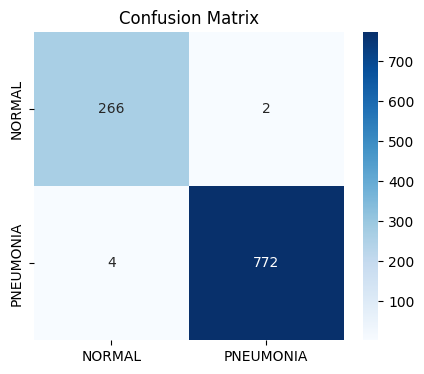

In [9]:

# ------------------ Classification Report ------------------
print("\nClassification Report:")
print(classification_report(val_targets, val_preds, target_names=class_names))

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()

In [10]:
# ------------------ Save Model ------------------
torch.save(model.state_dict(), "convnext_tiny_pneumonia_weighted.pth")
print("Model saved as convnext_tiny_pneumonia_weighted.pth")


Model saved as convnext_tiny_pneumonia_weighted.pth


### Using the model to predict new images

In [11]:

# --- Configuration ---
PATH = "convnext_tiny_pneumonia_weighted.pth"
CLASS_LABELS = ['Normal', 'Pneumonia']
NUM_CLASSES = len(CLASS_LABELS)
BATCH_SIZE = 16 # You can adjust this based on your GPU memory

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model Architecture and Weights (as previously defined)
try:
    model = models.convnext_tiny(weights=None)
    in_features = model.classifier[2].in_features
    model.classifier[2] = torch.nn.Linear(in_features, NUM_CLASSES)

    state_dict = torch.load(PATH, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print(f"✅ Model '{PATH}' loaded successfully on {device}.")

except Exception as e:
    print(f"❌ Error during model setup: {e}")
    exit()

# Define Preprocessing Transforms
inference_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

✅ Model 'convnext_tiny_pneumonia_weighted.pth' loaded successfully on cuda.


In [12]:


# --- Configuration (Define necessary variables) ---
BATCH_SIZE = 16 # Define the batch size
data_path_test = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/test")
NEW_IMAGES_FOLDER = data_path_test

# --- Define the Preprocessing Transforms (The missing piece) ---
inference_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create an ImageFolder Dataset
try:
    image_dataset = datasets.ImageFolder(
        root=NEW_IMAGES_FOLDER,
        transform=inference_transforms # Now defined!
    )

    # Create the DataLoader for batching
    image_loader = DataLoader(
        image_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count()
    )
    print(f"✅ Loaded {len(image_dataset)} images into the DataLoader.")

except Exception as e:
    print(f"❌ Error creating DataLoader: {e}")
    # The error is now less likely to be a NameError, but structure or path issues might remain.
    exit()

✅ Loaded 624 images into the DataLoader.


In [13]:


# --- Configuration --- (consolidated from earlier cells)
PATH = "convnext_tiny_pneumonia_weighted.pth"
CLASS_LABELS = ['Normal', 'Pneumonia']
NUM_CLASSES = len(CLASS_LABELS)
BATCH_SIZE = 32 # You can adjust this based on your GPU memory

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model Architecture and Weights
try:
    model = models.convnext_tiny(weights=None)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, NUM_CLASSES)

    state_dict = torch.load(PATH, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print(f"✅ Model '{PATH}' loaded successfully on {device}.")

except Exception as e:
    print(f"❌ Error during model setup: {e}")

# Define Preprocessing Transforms
inference_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Setup DataLoader for new images
data_path_test = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/test")
NEW_IMAGES_FOLDER = data_path_test

try:
    image_dataset = datasets.ImageFolder(
        root=NEW_IMAGES_FOLDER,
        transform=inference_transforms
    )

    image_loader = DataLoader(
        image_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count()
    )
    print(f"✅ Loaded {len(image_dataset)} images into the DataLoader for batch prediction.")

except Exception as e:
    print(f"❌ Error creating DataLoader: {e}")

def batch_predict(model, data_loader, class_labels, device):
    """Makes batch predictions and returns results in a readable format."""

    all_probabilities = []
    all_predictions = []

    # Disable gradient calculation for efficient inference
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)

            # Get model output (logits)
            outputs = model(inputs)

            # Convert logits to probabilities
            probabilities = torch.softmax(outputs, dim=1)

            # Get the predicted class index
            _, predicted = torch.max(probabilities, 1)

            # Collect results
            all_probabilities.extend(probabilities.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return all_predictions, all_probabilities

# Run the batch prediction
predicted_indices, predicted_probs = batch_predict(model, image_loader, CLASS_LABELS, device)


✅ Model 'convnext_tiny_pneumonia_weighted.pth' loaded successfully on cuda.
✅ Loaded 624 images into the DataLoader for batch prediction.


In [14]:
# Get the file paths from the dataset (needed for result mapping)
image_paths = [data[0] for data in image_dataset.samples]

# Compile the final results
results = []
for path, index, probs in zip(image_paths, predicted_indices, predicted_probs):
    result = {
        "Filename": os.path.basename(path),
        "Prediction_Index": index,
        "Predicted_Class": CLASS_LABELS[index],
        "Normal_Confidence": f"{probs[0]:.4f}",
        "Pneumonia_Confidence": f"{probs[1]:.4f}",
    }
    results.append(result)

# Print a summary of the first few results
print("\n" + "="*70)
print(f"✨ BATCH PREDICTION RESULTS ({len(results)} Total Images)")
print("="*70)

# Display a table for the first 5 results
print("| Filename | Predicted Class | Normal Confidence | Pneumonia Confidence |")
print("|---:|:---:|:---:|:---:|")
for i, res in enumerate(results):
    if i < 5:
        print(f"| {res['Filename'][:25] + '...' if len(res['Filename']) > 25 else res['Filename']} | **{res['Predicted_Class']}** | {res['Normal_Confidence']} | {res['Pneumonia_Confidence']} |")
    else:
        break

print("...")
print("="*70)



✨ BATCH PREDICTION RESULTS (624 Total Images)
| Filename | Predicted Class | Normal Confidence | Pneumonia Confidence |
|---:|:---:|:---:|:---:|
| IM-0001-0001.jpeg | **Normal** | 0.9875 | 0.0125 |
| IM-0003-0001.jpeg | **Normal** | 0.9688 | 0.0312 |
| IM-0005-0001.jpeg | **Pneumonia** | 0.4903 | 0.5097 |
| IM-0006-0001.jpeg | **Normal** | 0.9853 | 0.0147 |
| IM-0007-0001.jpeg | **Normal** | 0.9693 | 0.0307 |
...


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
from pathlib import Path

def count_files_pathlib(folder_path):
    """Counts the number of files (excluding directories) in a given folder."""
    try:
        folder = Path(folder_path)

        # Use glob('*') to get all entries, then filter to ensure they are files
        file_count = sum(1 for item in folder.iterdir() if item.is_file())

        return file_count

    except FileNotFoundError:
        return "Error: Folder path not found."
    except Exception as e:
        return f"An error occurred: {e}"


folder_1 = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA"
foldeer_2 = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL"
true = count_files_pathlib(folder_1)
false = count_files_pathlib(foldeer_2)
real_target = true + false
print(real_target)

624


In [17]:
390+234

624

In [18]:
#  Save the full list of results to a CSV or JSON file for further analysis.
df = pd.DataFrame(results)
df.to_csv("batch_predictions.csv", index=False)

In [19]:
df.head()

,Filename,Prediction_Index,Predicted_Class,Normal_Confidence,Pneumonia_Confidence
0,IM-0001-0001.jpeg,0,Normal,0.9875,0.0125
1,IM-0003-0001.jpeg,0,Normal,0.9688,0.0312
2,IM-0005-0001.jpeg,1,Pneumonia,0.4903,0.5097
3,IM-0006-0001.jpeg,0,Normal,0.9853,0.0147
4,IM-0007-0001.jpeg,0,Normal,0.9693,0.0307


In [20]:
df.Predicted_Class.value_counts()

,count
Predicted_Class,
Pneumonia,384
Normal,240


In [21]:
41+583

624

In [22]:

# Get true labels from the image_dataset (test set)
y_true_indices = image_dataset.targets

# Convert numerical labels to class names (e.g., 0 -> 'Normal', 1 -> 'Pneumonia')
y_true_labels = [CLASS_LABELS[idx] for idx in y_true_indices]

# Calculate confusion matrix using true labels and predicted labels
cm = confusion_matrix(y_true_labels, df.Predicted_Class)
cr = classification_report(y_true_labels, df.Predicted_Class)
# Print the confusion matrix (optional, as it will be plotted next)
print("Confusion Matrix:")
print(cm)
print('\n','\n', cr)


Confusion Matrix:
[[204  30]
 [ 36 354]]

 
               precision    recall  f1-score   support

      Normal       0.85      0.87      0.86       234
   Pneumonia       0.92      0.91      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.89      0.89      0.89       624



In [31]:
df['True_labels'] = y_true_labels
df.head()

,Filename,Prediction_Index,Predicted_Class,Normal_Confidence,Pneumonia_Confidence,True_labels
0,IM-0001-0001.jpeg,0,Normal,0.9875,0.0125,Normal
1,IM-0003-0001.jpeg,0,Normal,0.9688,0.0312,Normal
2,IM-0005-0001.jpeg,1,Pneumonia,0.4903,0.5097,Normal
3,IM-0006-0001.jpeg,0,Normal,0.9853,0.0147,Normal
4,IM-0007-0001.jpeg,0,Normal,0.9693,0.0307,Normal


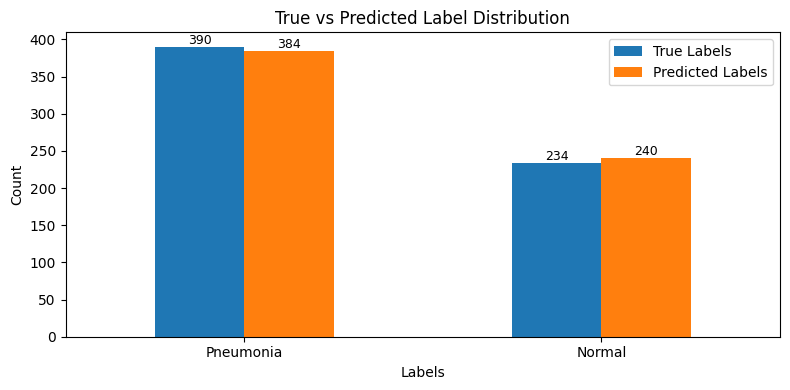

In [43]:

# Combine counts into one DataFrame
plot_df = pd.DataFrame({
    'True Labels': df.True_labels.value_counts(),
    'Predicted Labels': df.Predicted_Class.value_counts()
})

# Plot both on ONE axis
ax = plot_df.plot(kind='bar', figsize=(8,4))

ax.set_title("True vs Predicted Label Distribution")
ax.set_xlabel("Labels")
ax.set_ylabel("Count")
plt.xticks(rotation=0)


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()